# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import drd2, qed, similarity

## 2. Configure GPU (if available)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [4]:
PROPERTY_NAME = "qed"

SCORING_PROPERTY_FT = qed
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.8
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)¶

In [5]:
input_data_dir = os.path.join("DATA", PROPERTY_NAME)
input_ckpt_dir = os.path.join("outputs_Tutorial_1_MTMR_pretraining", PROPERTY_NAME)

In [6]:
_output_dir = "outputs_Tutorial_2_MTMR_finetuning-Copy2"
if not os.path.exists(_output_dir):
    os.mkdir(_output_dir)

output_dir = os.path.join(_output_dir, PROPERTY_NAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         scoring_ft=SCORING_PROPERTY_FT,
                                                         checkpoint_filepath=filepath_checkpoint,
                                                         total_steps=2000)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.045  reward: 0.575  similarity: 0.539  property: 0.855  valid_ratio(va): 1.000  similarity(va): 0.364  property(va): 0.748
[000010/002000]  loss: 0.047  reward: 0.575  similarity: 0.529  property: 0.859  valid_ratio(va): 0.997  similarity(va): 0.365  property(va): 0.773
[000020/002000]  loss: 0.050  reward: 0.614  similarity: 0.516  property: 0.868  valid_ratio(va): 0.997  similarity(va): 0.367  property(va): 0.787
[000030/002000]  loss: 0.044  reward: 0.612  similarity: 0.516  property: 0.870  valid_ratio(va): 1.000  similarity(va): 0.365  property(va): 0.795
[000040/002000]  loss: 0.046  reward: 0.623  similarity: 0.521  property: 0.870  valid_ratio(va): 0.994  similarity(va): 0.364  property(va): 0.796
[000050/002000]  loss: 0.047  reward: 0.647  similarity: 0.504  property: 0.874  valid_ratio(va): 1.000  similarity(va): 0.368  property(va): 0.805
[000060/002000]  loss: 0.041  reward: 0.650  similarity: 0.499  property: 0.874  valid_ratio(va): 1.000  similar

[000560/002000]  loss: 0.041  reward: 0.730  similarity: 0.470  property: 0.887  valid_ratio(va): 1.000  similarity(va): 0.342  property(va): 0.852
[000570/002000]  loss: 0.042  reward: 0.707  similarity: 0.468  property: 0.884  valid_ratio(va): 0.997  similarity(va): 0.340  property(va): 0.852
[000580/002000]  loss: 0.041  reward: 0.726  similarity: 0.469  property: 0.886  valid_ratio(va): 1.000  similarity(va): 0.340  property(va): 0.855
[000590/002000]  loss: 0.042  reward: 0.701  similarity: 0.476  property: 0.884  valid_ratio(va): 1.000  similarity(va): 0.343  property(va): 0.854
[000600/002000]  loss: 0.039  reward: 0.731  similarity: 0.480  property: 0.886  valid_ratio(va): 0.997  similarity(va): 0.343  property(va): 0.852
[000610/002000]  loss: 0.041  reward: 0.746  similarity: 0.464  property: 0.886  valid_ratio(va): 0.997  similarity(va): 0.341  property(va): 0.852
[000620/002000]  loss: 0.045  reward: 0.751  similarity: 0.466  property: 0.894  valid_ratio(va): 1.000  similar

[001120/002000]  loss: 0.040  reward: 0.742  similarity: 0.470  property: 0.890  valid_ratio(va): 0.997  similarity(va): 0.335  property(va): 0.863
[001130/002000]  loss: 0.041  reward: 0.735  similarity: 0.460  property: 0.890  valid_ratio(va): 0.997  similarity(va): 0.335  property(va): 0.862
[001140/002000]  loss: 0.041  reward: 0.696  similarity: 0.473  property: 0.887  valid_ratio(va): 0.997  similarity(va): 0.336  property(va): 0.862
[001150/002000]  loss: 0.040  reward: 0.758  similarity: 0.456  property: 0.889  valid_ratio(va): 1.000  similarity(va): 0.339  property(va): 0.866
[001160/002000]  loss: 0.042  reward: 0.745  similarity: 0.475  property: 0.893  valid_ratio(va): 1.000  similarity(va): 0.336  property(va): 0.864
[001170/002000]  loss: 0.041  reward: 0.733  similarity: 0.451  property: 0.889  valid_ratio(va): 1.000  similarity(va): 0.337  property(va): 0.864
[001180/002000]  loss: 0.043  reward: 0.746  similarity: 0.467  property: 0.892  valid_ratio(va): 1.000  similar

[001680/002000]  loss: 0.039  reward: 0.793  similarity: 0.457  property: 0.898  valid_ratio(va): 1.000  similarity(va): 0.337  property(va): 0.868
[001690/002000]  loss: 0.042  reward: 0.748  similarity: 0.443  property: 0.893  valid_ratio(va): 0.997  similarity(va): 0.336  property(va): 0.868
[001700/002000]  loss: 0.038  reward: 0.768  similarity: 0.461  property: 0.894  valid_ratio(va): 1.000  similarity(va): 0.336  property(va): 0.870
[001710/002000]  loss: 0.038  reward: 0.769  similarity: 0.465  property: 0.894  valid_ratio(va): 0.997  similarity(va): 0.337  property(va): 0.868
[001720/002000]  loss: 0.037  reward: 0.775  similarity: 0.483  property: 0.895  valid_ratio(va): 0.997  similarity(va): 0.332  property(va): 0.869
[001730/002000]  loss: 0.041  reward: 0.775  similarity: 0.475  property: 0.895  valid_ratio(va): 1.000  similarity(va): 0.333  property(va): 0.871
[001740/002000]  loss: 0.037  reward: 0.744  similarity: 0.471  property: 0.889  valid_ratio(va): 0.997  similar

## 10. Visualize for reward & loss analysis

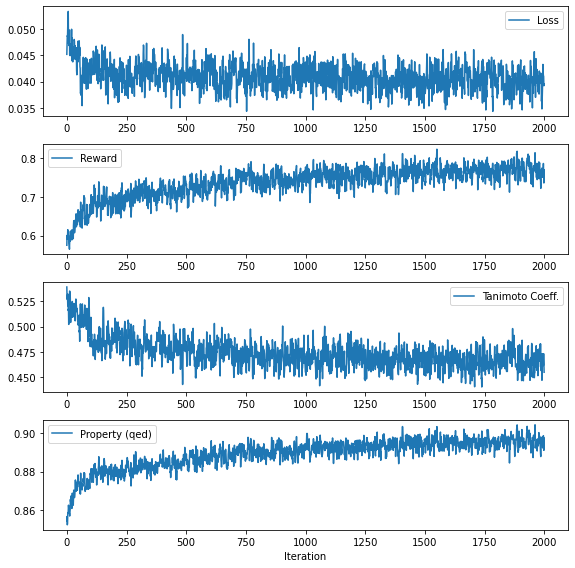

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

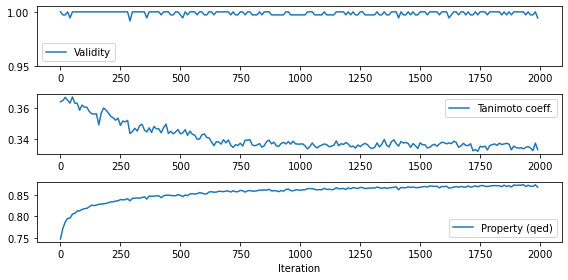

In [15]:
fig, axes = plt.subplots(3,1,figsize=(8,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()